In [6]:
using Revise

using LinearAlgebra, QuadGK, Roots, FFTW, FastGaussQuadrature, SpecialFunctions, StaticArrays
using Triangulate
using VlasovSolvers
import VlasovSolvers: advection!
import VlasovSolvers: Particles, WPM_step!, ParticleMover, kernel_poisson!, kernel_gyrokinetic!, kernel_freestreaming!

using ProgressMeter, Printf
using Plots, LaTeXStrings

include("numerical_examples.jl");

# Quadrature rules

In [7]:
struct RectangleRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function RectangleRule(len, start, stop)
        points = LinRange(start, stop, len+1)[1:end-1]
        s = step(points) 
        weights = [s for _ = 1:len]
        new(len, start, stop, vec(points), weights, s)
    end
end

In [8]:
struct TrapezoidalRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function TrapezoidalRule(len, start, stop)
        points = LinRange(start, stop, len)[1:end]
        s = step(points) 
        weights = [s for _ = 1:len]
        weights[1] /= 2
        weights[end] /= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [9]:
struct SimpsonRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function SimpsonRule(len, start, stop)
        # make sure the number of points is uneven
        if len % 2 == 0
            len += 1
        end
        points = LinRange(start, stop, len)
        s = step(points) 
        weights = s/3 .* ones(len)
        weights[2:2:end-1] .*= 4
        weights[3:2:end-2] .*= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [10]:
struct GaussHermiteRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussHermiteRule(len, start, stop)
        points, weights = gausshermite(len)
        weights .*= exp.(points.^2)
        new(len, start, stop, points, weights)
    end
end

In [11]:
struct GaussLegendreRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLegendreRule(len, start, stop)
        points, weights = gausslegendre(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [12]:
struct GaussRadauRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussRadauRule(len, start, stop)
        points, weights = gaussradau(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [13]:
struct GaussLobattoRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLobattoRule(len, start, stop)
        points, weights = gausslobatto(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [14]:
struct KronrodRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function KronrodRule(len, start, stop)
        pts, w, _ = kronrod(len)
        weights = []
        points = []
        for i = 1:len
            push!(points, pts[i])
            push!(weights, w[i])
            push!(points, -pts[i])
            push!(weights, w[i])
        end
        push!(points, pts[end])
        push!(weights, w[end])
        
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        len = 2*len + 1
        new(len, start, stop, points, weights)
end
    end

In [15]:
# Only works for rectangle and trapezoidal rules
function projection_onto_grid!(grid_dst, meshx, meshv, X, V_, W)
    meshxstep = meshx[2] - meshx[1]
    meshvstep = meshv[2] - meshv[1]
    grid_dst .= 0


    # Periodic Boundary conditions on velocity
    V = copy(V_)
    V[findall(v -> v >= meshv[end],  V)] .-= meshv[end] - meshv[1]
    V[findall(v -> v < meshv[1],  V)] .+= meshv[end] - meshv[1]
    
    for ipart = 1:length(X)
        idxgridx = Int64(fld(X[ipart],            meshxstep)) + 1
        idxgridv = Int64(fld(V[ipart] - meshv[1], meshvstep)) + 1
        idxgridxp1 = idxgridx<length(meshx) ? idxgridx+1 : 1
        idxgridvp1 = idxgridv<length(meshv) ? idxgridv+1 : 1
        
        tx = (X[ipart]             - (idxgridx-1) * meshxstep) / meshxstep
        tv = (V[ipart] - meshv[1]  - (idxgridv-1) * meshvstep) / meshvstep

        # println((idxgridv, V[ipart]))
        grid_dst[idxgridx  , idxgridv  ] += W[ipart] * (1-tx) * (1-tv)
        grid_dst[idxgridx  , idxgridvp1] += W[ipart] * (1-tx) * tv
        grid_dst[idxgridxp1, idxgridvp1] += W[ipart] * tx     * tv
        grid_dst[idxgridxp1, idxgridv  ] += W[ipart] * tx     * (1 - tv)
    end
end

projection_onto_grid! (generic function with 1 method)

# BSL

In [16]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64}; K=1)

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    kernel = zeros(Float64, n1)
    ker = -(mesh1.stop - mesh1.start) / (2π)
    for k=1:K
        kernel[1+k]   =  ker / k    # fourier mode  1
        kernel[end - (k-1)] = -ker / k    # fourier mode -1
    end
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end

function solve_BSL!(nsteps, dt, f, mesh1, mesh2, kx; plotting=false::Bool, K=1)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    results = (Eelec² = Array{Float64}(undef, nsteps),
                Etot² = Array{Float64}(undef, nsteps),
                momentum = Array{Float64}(undef, nsteps),
                L²norm² = Array{Float64}(undef, nsteps))


    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex, K=K)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        results.Eelec²[istep] = sum(ex.^2) * mesh1.step
        results.Etot²[istep] = (results.Eelec²[istep] + sum(mesh2.points'.^2 .* real(f)) * mesh1.step * mesh2.step) / 2
        results.momentum[istep] = sum(sum(real(f), dims=1) .* mesh2.points') * mesh1.step * mesh2.step
        results.L²norm²[istep] = sum(real(f).^2) * mesh1.step * mesh2.step
    
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex, K=K)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        
        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
        
    return results, animation
end

solve_BSL! (generic function with 1 method)

# WPM

In [37]:
function solve_WPM!(nsteps, dt, particles, example, weights; 
                    plotting=false::Bool, kernel=kernel_poisson!, R=NaN, K=1)
    init_pos = copy(particles.x)
    init_vel = copy(particles.v)

    np = particles.nbpart

    results = (Eelec² = Array{Float64}(undef, nsteps),
                Etot² = Array{Float64}(undef, nsteps),
                momentum = Array{Float64, 2}(undef, length(particles.v[:, 1]), nsteps),
                L²norm² = Array{Float64}(undef, nsteps),
                C = Array{Float64,example.dim+1}(undef, fill(2K + 1, example.dim)..., nsteps), 
                S = Array{Float64,example.dim+1}(undef, fill(2K + 1, example.dim)..., nsteps))

    pmover = ParticleMover{particles.type, particles.dim}(particles, example.L, K, dt)
    kernel_poisson!(pmover.∂Φ, particles.x, particles, pmover) # to initialize pmover.∂Φ, in case splitting is used

    if (plotting)&&(example.dim==1)
        widthx = example.L[1]
        widthv = 2example.vmax[1]
        scale = 0.5
        plotEelec = plot([], [], xlim=(0, nsteps*dt), yaxis=:log10)
    end
    
    progression = ProgressMeter.Progress(nsteps, desc="Loop in time: ", showspeed=true)
    animation = @animate for istep = 1:nsteps
        WPM_step!(particles, pmover; kernel=kernel)
        results.momentum[:, istep] = pmover.momentum 
        (results.Eelec²[istep], results.Etot²[istep]) = pmover.Eelec²tot²

        results.S[fill(:,example.dim)..., istep] .= pmover.S
        results.C[fill(:,example.dim)..., istep] .= pmover.C
        
        # L² norm:
        results.L²norm²[istep] = 0.0
        for i = 1:particles.nbpart
            results.L²norm²[istep] += particles.β[i]^2 / vec(weights)[i]
        end
        
        if (istep % R == 0) && (example.dim==1)
            particles.β .= triangulation_interpolation(particles.β ./ vec(weights), particles.x[1, :], 
                                                        particles.v[1, :], 
                                                        init_pos[1, :], init_vel[1, :], example)[1]
            particles.β .*= vec(weights)
            particles.x .= init_pos
            particles.v .= init_vel
        end
        
        if (plotting)&&(example.dim==1)
            plotParts = plot(particles.x[1, :], particles.v[1, :], seriestype=:scatter, zcolor=vec(particles.β), 
                markersize=sqrt(0.1) * scale, zticks=[], camera=(0, 90), 
                markerstrokecolor="white", markerstrokewidth=0, label="", c=:jet1,
                size=(600, 600), 
                title="t = $(@sprintf("%.3f",istep*dt))\nProgression: $(round(Int64,100*progression.counter / progression.n))%", titlefontsize=8, margin=5Plots.mm)
            push!(plotEelec, istep*dt, sqrt(results.Eelec²[istep]))
            plot(plotParts, plotEelec, layout=@layout [a;b])
        end

        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    
    return results, animation
end

solve_WPM! (generic function with 1 method)

# Triangulation

In [18]:
function triangulation_interpolation(_valsf, _pos, _vel, gridxoutput, gridvoutput, example; 
                                        returntriangulation=false)
    """
    Perform a linear interpolation of the data to the grid by using a Delaunay triangulation.

    Steps:
    1. Create the Delaunay triangulation
    2. For each point (x,v) in (gridxoutput, gridvoutput)
        a. Get the triangle T in which (x,v) lies, by iterating over all the triangles and testing each one of them
        b. From the vertices of T get a linear interpolation of the function at x, using barycentric coordinates
    """
    
    myoutput = similar(gridxoutput)

    pointset = Triangulate.TriangulateIO()

    # Copy some rightmost particles to the left, and some leftmost particles to the right. 
    # This allows to interpolate values from a periodic triangulation.
    κ = 1/20
    rightmost_particles = findall(>((1 - κ) * example.L[1]), _pos)
    leftmost_particles = findall(<(κ * example.L[1]), _pos)
    
    pos = append!(_pos[rightmost_particles] .- example.L[1], _pos  , _pos[leftmost_particles] .+ example. L[1])
    vel = append!(_vel[rightmost_particles]             , _vel  , _vel[leftmost_particles])
    valsf = append!(_valsf[rightmost_particles]         , _valsf, _valsf[leftmost_particles])
    
    @views pointset.pointlist = vcat(pos', vel')
    pointset.pointattributelist = valsf'
    (triangulation, _) = Triangulate.triangulate("Q", pointset);

    # Interpolate using the triangulation
    @views @inbounds for part=eachindex(gridxoutput)
        myoutput[part] = triangleContainingPoint(triangulation, gridxoutput[part], gridvoutput[part])[1]
        (myoutput[part] < 0) && (myoutput[part] = 0) 
        # Usually happens in corners or at the top, so we can reasonably suppose the value if small enough to be 
        # approximated by zero.
    end

    returntriangulation ? nothing : triangulation=nothing
    return vec(myoutput), triangulation
end


function triangleContainingPoint(triangulation, x, v)
    @views @inbounds for (idxA, idxB, idxC) = eachcol(triangulation.trianglelist)
        
        A = triangulation.pointlist[:, idxA]
        B = triangulation.pointlist[:, idxB]
        C = triangulation.pointlist[:, idxC]
        
        # if x is outside of the rectangle defined by [minX(A, B, C), maxX(A, B, C)],
        # or v is outside of the rectangle defined by [minV(A, B, C), maxV(A, B, C)],
        # then we don't have to do the computations
        if      ((x < A[1]) && (x < B[1]) && (x < C[1])) || ((x > A[1]) && (x > B[1]) && (x > C[1]))
            continue
        elseif  ((v < A[2]) && (v < B[2]) && (v < C[2])) || ((v > A[2]) && (v > B[2]) && (v > C[2]))
            continue
        end
        
        # Use barycentric coordinates:
        det = (A[1] - C[1])*(B[2] - C[2]) - (A[2] - C[2])*(B[1] - C[1])
        λ₁ = (x - C[1])*(B[2] - C[2]) + (v - C[2])*(C[1] - B[1])
        λ₂ = (x - C[1])*(C[2] - A[2]) + (v - C[2])*(A[1] - C[1])
        λ₁ /= det 
        λ₂ /= det
        
        if (λ₁≥0)&&(λ₂≥0)&&(λ₁+λ₂≤1)
            wA = triangulation.pointattributelist[1, idxA]
            wB = triangulation.pointattributelist[1, idxB]
            wC = triangulation.pointattributelist[1, idxC]
            return wA * λ₁ + wB * λ₂ + (1 - λ₁ - λ₂) * wC, (idxA, idxB, idxC)
        end
    end

    return -1., (-1, -1, -1)
end

triangleContainingPoint (generic function with 1 method)

# Inputs

In [114]:
dev = CPU()

# example = example_landaudamping_1D
# example = example_stronglandaudamping_1D
# example = example_landaudamping_2D
# example = example_twostreaminstability_1D
# example = example_twostreaminstabilityalternativeformulation_1D
# example = example_bumpontail_1D
example = example_stationarygaussian_1D
# example = example_nonhomogeneousstationarysolution_1D
# example = example_test_1D

# example = example_landaudamping_1D = LandauDamping_ND(; alpha=0.001, kxs=[0.5], mu=[0.0], beta=[1.0], shortname="Landau_1D", longname="Weak Landau damping 1D", L=nothing, vmax=[6.0]);

T = 100
dt = 0.1
nstep = convert(Int64, floor(T/dt))

nxbsl = 128
nvbsl = 128
# 
mytype = Float64
meshx = OneDGrid{mytype}(dev, nxbsl, convert(mytype, 0.), convert(mytype, example.L[1]));
meshv = OneDGrid{mytype}(dev, nvbsl, convert(mytype, example.vmin[1]), convert(mytype, example.vmax[1]));

quadX = RectangleRule
quadV = GaussHermiteRule
nxwpm = 128
nvwpm = 128
quadrulesx = [quadX(nxwpm, 0, example.L[d]) for d=1:example.dim];
quadrulesv = [quadV(nvwpm, example.vmin[d], example.vmax[d]) for d=1:example.dim];

In [115]:
bsl = zeros(Complex{Float64}, (nxbsl, nvbsl));
@. bsl = example.f0.(meshx.points, meshv.points');
@time resBSL, animBSL = solve_BSL!(nstep, dt, bsl, meshx, meshv, example.kxs[1]; plotting=false, K=1);

Loop in time: 100%|███████████████████████| Time: 0:00:05 ( 5.22 ms/it)


  5.223508 seconds (493.11 k allocations: 1.170 GiB, 5.02% gc time)


In [116]:
if animBSL != nothing
    gif(animBSL, "gif/tmp.mp4");
end

# Weighted-Particle method

In [117]:
R = NaN
dim = example.dim

nbparticles = *(fill(nxwpm, dim)...) * *(fill(nvwpm, dim)...)

x0_init = map(x->[xx for xx=x], vec(collect(Base.product([rulex.points for rulex = quadrulesx]...))))
v0_init = map(v->[vv for vv=v], vec(collect(Base.product([rulev.points for rulev = quadrulesv]...))))
x = map(z->z[1], vec(collect(Base.product(x0_init, v0_init))))
v = map(z->z[2], vec(collect(Base.product(x0_init, v0_init))))

wx = map(prod, vec(collect(Base.product([rulex.weights for rulex = quadrulesx]...))))
wv = map(prod, vec(collect(Base.product([rulev.weights for rulev = quadrulesv]...))))
weights = map(prod, vec(collect(Base.product(wx, wv))))

fvals = example.f0.(x, v)
wei = fvals .* weights

x0 = reduce(hcat, x)
v0 = reduce(hcat, v)

particles = Particles{mytype}(x0, v0, wei);

K=1
@time resWPM, animWPM = solve_WPM!(nstep, dt, particles, example, weights;
                                    plotting=false, kernel=kernel_poisson!, R=R, K=K);

Loop in time: 100%|███████████████████████| Time: 0:00:03 ( 3.83 ms/it)


  3.834108 seconds (92.72 k allocations: 5.102 MiB)


In [118]:
if animWPM != nothing
    # gif(animWPM, "gif/nonstationary_remapping_T$(@sprintf("%03d", T)).mp4");
    gif(animWPM, "gif/tmp_landau_damping.mp4");
end

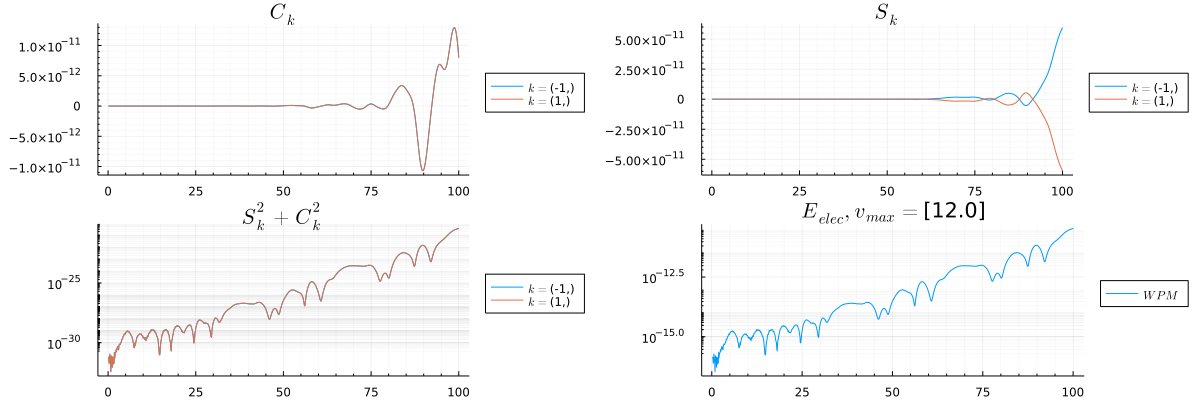

In [119]:
t = (1:nstep) .* dt

plotCk = plot(minorgrid=true, size=(600, 400), legend=:outerright)
@views for idxk = CartesianIndices(view(resWPM.C, fill(:, example.dim)..., 1))
    k = idxk.I .- (K+1)
    (sum(abs.(k)) == 0 || sum(abs.(k)) > K) && continue
    plot!(t, resWPM.C[idxk, :], label=L"k="*"$(k)")
end
title!(L"C_k")

plotSk = plot(minorgrid=true, size=(600, 400), legend=:outerright)
@views for idxk = CartesianIndices(view(resWPM.S, fill(:, example.dim)..., 1))
    k = idxk.I .- (K+1)
    (sum(abs.(k)) == 0 || sum(abs.(k)) > K) && continue
    plot!(t, resWPM.S[idxk, :], label=L"k="*"$(k)")
end
title!(L"S_k")

plotCk²Sk² = plot(minorgrid=true, size=(600, 400), yaxis=:log10, legend=:outerright)
ε = 0
@views for idxk = CartesianIndices(view(resWPM.S, fill(:, example.dim)..., 1))
    k = idxk.I .- (K+1)
    (sum(abs.(k)) == 0 || sum(abs.(k)) > K) && continue
    plot!(t, resWPM.S[idxk, :].^2 .+ resWPM.C[idxk, :].^2, label=L"k="*"$(k)")
end
title!(L"S_k^2 + C_k^2")

plotEelec = plot(minorgrid=true, size=(600, 400), yaxis=:log10, legend=:outerright)
plot!(t .+ dt, max.(ε, sqrt.(resWPM.Eelec²)), label=L"WPM")
slope = -0.1533
# plot!(t .- dt/2, max.(ε, sqrt.(resBSL.Eelec²)), label=L"BSL")
# plot!(x->exp(slope*x - 5.6), 0, T/2, label="$slope")
title!(L"E_{elec}, v_{max}="*"$(example.vmax)")

plot(plotCk, plotSk, plotCk²Sk², plotEelec, size=(1200, 400), layout=@layout [a b; c d])

## Plot particles

In [ ]:
plot(particles.x, particles.v, seriestype=:scatter, markersize=sqrt(600*600 / (nxbsl*nvbsl) / π) * 0.5, camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=particles.wei, c=:jet1, size=(600, 600), right_margin=5Plots.mm)

## Triangulation interpolation

In [ ]:
function plot_triangulation(tri; p=nothing, scaled=false)
    if p==nothing 
        p = plot()
    end

    @views begin
        x1 = tri.pointlist[1, tri.trianglelist'[:, 1]]'
        x2 = tri.pointlist[1, tri.trianglelist'[:, 2]]'
        x3 = tri.pointlist[1, tri.trianglelist'[:, 3]]'
        posX = vec(vcat(x1, x2, x3, x1, NaN*similar(x1)))
        v1 = tri.pointlist[2, tri.trianglelist'[:, 1]]'
        v2 = tri.pointlist[2, tri.trianglelist'[:, 2]]'
        v3 = tri.pointlist[2, tri.trianglelist'[:, 3]]'
        posV = vec(vcat(v1, v2, v3, v1, NaN*similar(v1)))
    end
    if scaled 
        posX .-= 1; posX .*= example.L
        posV .-= 1; posV .*= example.vmax - example.vmin; posV .+= example.vmin;
    end
    plot!(p, posX, posV, c=:rainbow, label="Delaunay Triangulation", linewidth=0.1)
    return p
end

In [ ]:
(newf, triangulation) = triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, x0_init, v0_init, example; returntriangulation=true)
newf .*= vec(weights);

In [ ]:
p1 = plot(particles.x, particles.v, seriestype=:scatter, 
        markersize=sqrt(600*600 / (nxwpm*nvwpm) / π) * 0.4, camera=(0, 90), 
        markerstrokecolor="white", markerstrokewidth=0, label="Particules", zcolor=newf,
        title=example.shortname * "\n($(quadX)($(nxwpm)), $(quadV)($(nvwpm)))", titlefontsize=8, c=:jet1)

plot_triangulation(triangulation; p=p1)
# p2 = plot(x0_init, v0_init, newf, st=:surface, camera=(0, 90), title="Interpolated", titlefontsize=8, c=:jet1)
# p2 = plot(quadrulex.points, quadrulev.points, reshape(newf, nx, nv)', st=:contour, title="Interpolated", titlefontsize=8, c=:jet1, levels=25)
# plot(p1, p2, size=(1200, 600))
plot(p1)
# plot(p2)

### Successive interpolations

In [ ]:
newf = copy(particles.wei) ./ vec(weights)
newx = copy(particles.x)
newv = copy(particles.v)

myplots = []

push!(myplots, plot(particles.x, particles.v, seriestype=:scatter, markersize=1, camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=particles.wei, c=:jet1, zticks=[], colorbar=false, titlefontsize=8))
title!(example.shortname * "\n($quadX($nxwpm), $quadV($nvwpm)),\nafter time $(nstep*dt)", titlefontsize=8)

tokeep = [1, 2, 5, 10, 20]
@showprogress for i = 1:maximum(tokeep)
    (newf, triangulation) = triangulation_interpolation(newf, newx, newv, x0_init, v0_init, example; returntriangulation=true)
    (i ∈ tokeep) && (push!(myplots, plot(x0_init, v0_init, newf .* vec(weights), st=:surface, camera=(0, 90), title="Interpolated $i times", titlefontsize=8, c=:jet1, zcolor=particles.wei, colorbar=false, zticks=[],
    margin=10Plots.mm)))
    # we now know `newf` at x0_init, v0_init so we update newx, newv
    newx = copy(x0_init) .+ rand() * (quadrulex.points[2] - quadrulex.points[1]) * 0.5
    newv = copy(v0_init) .+ rand() * (quadrulev.points[2] - quadrulev.points[1]) * 0.5
end

In [ ]:
cbar = scatter([0,0], [0,1], zcolor=particles.wei,
                xlims=(1,1.1), xshowaxis=false, xticks=[],
                yshowaxis=false, yticks=[],
                label="", c=:jet1, grid=false, 
                left_margin=25Plots.mm, right_margin=3Plots.mm)

l = @layout [
    [grid(2,3)] a{0.01w}
]
plot(myplots..., cbar, layout=l, size=(1000, 600))

In [ ]:
# savefig(imgdir * "$(example.shortname)_successive_interpolations_afterfixing_periodic.png")

# Plots

In [ ]:
t = (1:nstep) .* dt
ε = 1e-18

plot(legend=:outertop, minorgrid=true, size=(600, 400))

# energies
# plot!(t .+ dt,   resWPM.Eelec, label=L"\log_{10}(E_{elec, WPM}),\quad dt="*"$(dt)")
# plot!(t .- dt/2, resBSL.Eelec, label=L"\log_{10}(E_{elec, BSL}),\quad dt="*"$(dt)", ls=:dash, lw=1)

# log(Energies)
plot!(t .+ dt,   max.(ε, sqrt.(resWPM.Eelec²)), label=L"E_{elec, WPM}\quad dt="*"$(dt)", yaxis=:log)
plot!(t .- dt/2, max.(ε, sqrt.(resBSL.Eelec²)), label=L"E_{elec, BSL}\quad dt="*"$(dt)", ls=:dash, lw=1, yaxis=:log)
# plot!(t, log.(E_tot),       label=L"\log(E_{tot}),\quad dt="*"$(dt)")
# plot!(t, log.(E_elecpic), label=L"$\log(E_{elec, PIC}),\quad$ dt="*"$(dt), "* L"$n_p$ ="*"$(nbparticlespic)", ls=:dot)
# plot!(t, log.(energy_from_projection), label=L"\log(E_{pic, PIC}),\quad dt="*"$(dt)")
# plot!(t, log.(energy_elec_from_phi), label=L"\log(E_{from\,\Phi, PIC}),\quad dt="*"$(dt)")


# ============== #

# Landau damping (kx=0.5):
# plot!(x->exp(-0.1533x - 5.6), label="Damping attendu (-0.1533)")
# slope = -0.394
# plot!(x->exp(slope*x - 0.9), label="Theoretical damping ($slope)")
# E_th = abs.(4ϵ * 0.3677 .* exp.(−0.1533 .* t) .* cos.(1.4156.*t .−0.5326245)) * sqrt(L/2)
# plot!(t, log.(E_th),label="Energie theorique")
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu (-0.0661)")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
# E_th = abs.(4*example.α*0.3677*exp.(-0.1533 .* t) .* cos.(1.4156 .* t .- 0.536245) * sqrt(example.L/2)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
# plot!(t, E_th,label="Energie theorique", ls=:dashdotdot)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.2, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.7, label=L"y=0.086671t - 3.7")

title!(example.longname * "\n($(quadX)($(nxwpm)), $(quadV)($(nvwpm))), vmax = $(example.vmax)", titlefontsize=8)
xlabel!("t (R=$(R))")
# xlabel!("time")

In [ ]:
example.L[1] / (2example.vmax[1] / nvwpm)

In [ ]:
savefig(imgdir*"/tmp.png")

# Plot annotations

In [ ]:
# period = 2π / 1.4156
# vline!(vcat([4 + i*period for i=0:4], [49.5 + i*period for i=0:3]), label="")
ω = 1.676
vline!([1.75 + i* 2π/ω for i=0:2], label="ω = $ω")

In [ ]:
plot!([49.5, 49.5+period], [-10, -10], arrow=arrow(:closed, :both), label="")
annotate!((51.5, -10.3, text(L"\frac{2\pi}{1.4156}", :top, 10)))

# Quantités conservatives

## Variation d'énergie totale

In [ ]:
p11 = plot(t, resWPM.Etot², label="", minorgrid=true, xlabel="t")
hline!(p11, [example.Etot²exact], label="Exact")
title!(p11, "E_tot^2 (WPM)")
p12 = plot(t, max.(ε, abs.(resWPM.Etot² .- example.Etot²exact)), label="", minorgrid=true, xlabel="t", yaxis=:log)
title!(p12, "|WPM - exact|")
p21 = plot(t, resBSL.Etot², label="", minorgrid=true, xlabel="t")
hline!(p21, [example.Etot²exact], label="Exact")
title!(p21, "E_tot^2 (BSL)")
p22 = plot(t, max.(ε, abs.(resBSL.Etot² .- example.Etot²exact)), label="", minorgrid=true, yaxis=:log, xlabel="t")
title!(p22, "|BSL - exact|")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

## Variations du moment

In [ ]:
p11 = plot(t, resWPM.momentum[1, :], label="", minorgrid=true, xlabel="t")
hline!(p11, [example.momentumexact], label="Exact")
title!(p11, "Momentum (WPM)")
p12 = plot(t, max.(ε, abs.(resWPM.momentum[1, :] .- example.momentumexact)), label="", minorgrid=true, xlabel="t", yaxis=:log)
title!(p12, "|WPM - exact|")
p21 = plot(t, resBSL.momentum, label="", minorgrid=true, xlabel="t")
hline!(p21, [example.momentumexact], label="Exact")
title!(p21, "Momentum (BSL)")
p22 = plot(t, max.(ε, abs.(resBSL.momentum .- example.momentumexact)), label="", minorgrid=true, yaxis=:log, xlabel="t")
title!(p22, "|SL - exact|")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

## Variations norme $L^2$

In [ ]:
p11 = plot(t, resWPM.L²norm², label="", minorgrid=true, xlabel="t")
hline!(p11, [example.L²norm²exact], label="Exact")
title!(p11, "(Norme L^2)^2 (WPM)")
p12 = plot(t, max.(ε, abs.(resWPM.L²norm² .- example.L²norm²exact)), label="", minorgrid=true, xlabel="t", yaxis=:log)
title!(p12, "WPM - exact")
p21 = plot(t, resBSL.L²norm², label="", minorgrid=true, xlabel="t")
hline!(p21, [example.L²norm²exact], label="Exact")
title!(p21, "(Norme L^2)^2 (BSL)")
p22 = plot(t, max.(ε, abs.(resBSL.L²norm² .- example.L²norm²exact)), label="", minorgrid=true, yaxis=:log, xlabel="t")
title!(p22, "BSL - exact")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

## Visualisation des points de quadrature

In [ ]:
visualization_quadrulex = RectangleRule(32, 0, example.L)
visualization_quadrulev = GaussHermiteRule(64, example.vmin, example.vmax)

gridx_init = copy(vec(repeat(visualization_quadrulex.points, 1, visualization_quadrulev.len)))
gridv_init = copy(vec(repeat(visualization_quadrulev.points', visualization_quadrulex.len, 1)))
plot(gridx_init, gridv_init, seriestype=:scatter, markersize=sqrt(600*600 / (nxwpm*nvwpm) / π) * 0.5, camera=(0, 90), markerstrokecolor=nothing, markerstrokewidth=0, label="", zcolor=vec(example.f0.(gridx_init, gridv_init')), c=:rainbow)

# Other quantities of interest

## $\int f dv$, $\int fdx$

In [ ]:
function ∫f(pos, w, mesh)
    toplot = Float64[]
    for p=mesh.points
        push!(toplot, sum(w[findall((pos .>= p) .&& (pos .< (p + mesh.step)))]))
    end
    return toplot
end

In [ ]:
instant = nstep

valstoplot = ∫f(particles.x, particles.wei ./ meshx.step, meshx) # ∫fdv
p1 = plot(meshx.points .+ meshx.step/2, valstoplot,
            label="WPM ($(nxwpm)×$(nvwpm))", minorgrid=true)
plot!(p1, meshx.points, vec(sum(real(bsl), dims=2)) .* meshv.step, 
        label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
title!(p1, "$(example.shortname), ∫f(t^$(instant),x,v)dv")
xlabel!(p1, "x")


valstoplot = ∫f(particles.v, particles.wei ./ meshv.step, meshv) # ∫fdx
p2 = plot(meshv.points .+ meshv.step/2, valstoplot,
            label="WPM ($(nxwpm)×$(nvwpm))", minorgrid=true)
plot!(p2, meshv.points, vec(sum(real(bsl), dims=1)) .* meshx.step,
        label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
title!(p2, "$(example.shortname), ∫f(t^$(instant),x,v)dx")
xlabel!(p2, "v")


p12 = plot(p1, p2, size=(1000, 500), margin=10Plots.mm)
display(p12)

# imgdir = "../../../latex/imgs/png/integrals_f_dx_or_dv/" # Folder in which to store images 
# savefig(imgdir*"$(example.shortname)_t$(nstep)_$(nxwpm)_$(nvwpm).png")

(newf, _) = triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, x0_init, v0_init, example; returntriangulation=false)
newf .*= vec(weights);

valstoplot = ∫f(x0_init .+ 100eps(), newf ./ meshx.step, meshx) # ∫fdv
p1 = plot(meshx.points, valstoplot,
            label="WPM ($(nxwpm)×$(nvwpm))", minorgrid=true)
plot!(p1, meshx.points, vec(sum(real(bsl), dims=2)) .* meshv.step, 
        label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
title!(p1, "$(example.shortname), ∫f(t^$(instant),x,v)dv")
xlabel!(p1, "x")

valstoplot = ∫f(v0_init .+ 100eps(), newf ./ meshv.step, meshv) # ∫fdx
p2 = plot(meshv.points, valstoplot,
            label="WPM ($(nxwpm)×$(nvwpm))", minorgrid=true)
plot!(p2, meshv.points, vec(sum(real(bsl), dims=1)) .* meshx.step,
        label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
title!(p2, "$(example.shortname), ∫f(t^$(instant),x,v)dx")
xlabel!(p2, "v")

p12 = plot(p1, p2, size=(1000, 500), margin=10Plots.mm)

## Coupe à $x$ fixé

In [ ]:
function coupe_x_fixe(posofslice, x, v, w; width=0.1)
    proj_to_slice = []
    for part = 1:nbparticles 
        ((x[part] < posofslice - width/2) || (x[part] > posofslice + width/2)) && continue
        push!(proj_to_slice, part)
    end
    permutation = sortperm(v[proj_to_slice])
    return v[proj_to_slice][permutation], w[proj_to_slice][permutation]
end

In [ ]:
instant = 1
width   = 0.5
sliceat = example.L/5
plot(coupe_x_fixe(sliceat, resWPM.historyX[:, instant], resWPM.historyV[:, instant], particles.wei; width=width)..., label="WPM")
title!("f(t=t^$(instant-1), x ± "*@sprintf("%.4f", width)*", ⋅)")
xlabel!("v")

## Coupe à $v$ fixé

In [ ]:
function coupe_v_fixe(posofslice, x, v, w; width=0.1)
    proj_to_slice = []
    for part = 1:nbparticles 
        ((v[part] < posofslice - width/2) || (v[part] > posofslice + width/2)) && continue
        push!(proj_to_slice, part)
    end
    permutation = sortperm(x[proj_to_slice])
    return x[proj_to_slice][permutation], w[proj_to_slice][permutation]
end

In [ ]:
instant = 3
width   = 0.2
sliceat = 0.
plot(coupe_v_fixe(sliceat, particles.x, particles.v, particles.wei; width=width)..., label="WPM")
plot!
title!("f(t=t^$(instant-1), x ± "*@sprintf("%.4f", width)*", ⋅)")
xlabel!("x")

# Repeated plots

In [ ]:
using Printf

# arr_examples = [example_landaudamping, example_stronglandaudamping, example_twostreaminstability, 
#                 example_bumpontail, example_stationarygaussian, example_nonhomogeneousstationarysolution]
arr_examples = [example_stationarygaussian]
arr_T = [10, 50, 101, 201, 250, 400, 500, NaN]

for example = arr_examples
    println(example.longname * " (" * example.shortname * ")")
    flush(stdout)

    nstep = 1000
    dt = 0.1

    nx = 127
    nv = 129

    meshx = OneDGrid(dev, nx, 0, example.L);
    meshv = OneDGrid(dev, nv, example.vmin, example.vmax);

    quadX = RectangleRule
    quadV = RectangleRule

    quadrulex = quadX(nx, 0, example.L);
    quadrulev = quadV(nv, example.vmin, example.vmax);

    nbparticles = nx*nv
    t = (1:nstep) .* dt
    
    bsl = zeros(Complex{Float64}, (nx,nv));
    @. bsl = example.f0.(meshx.points, meshv.points');
    resBSL, animBSL = solve_BSL!(nstep, dt, bsl, meshx, meshv, example.kx; plotting=false);

    for T = arr_T 
        println("T=$(@sprintf("%03d", T))")
        flush(stdout)

        x0_init = copy(vec(repeat(quadrulex.points, 1, quadrulev.len)))
        v0_init = copy(vec(repeat(quadrulev.points', quadrulex.len, 1)))
        x0 = copy(vec(repeat(quadrulex.points, 1, quadrulev.len)))
        v0 = copy(vec(repeat(quadrulev.points', quadrulex.len, 1)))
        weights = quadrulex.weights .* quadrulev.weights'
        wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* weights)
        # println("WPM:")
        # flush(stdout)
        p = Particles(x0, v0, wei, nbparticles);
        resWPM, animWPM = solve_WPM!(nstep, dt, p, meshx, example, vec(weights) ; 
                                            plotting=false, kernel=kernel_poisson!, T=T);



        plot(legend=:bottomright, minorgrid=true, size=(600, 400))
        plot!(t .+ dt, log10.(resWPM.Eelec), label=L"E_{elec, WPM}\quad dt="*"$(dt)")
        plot!(t, log10.(resBSL.Eelec), label=L"E_{elec, BSL}\quad dt="*"$(dt)", ls=:dash, lw=1)
        title!(example.shortname * "\n($(quadX)($(nx)), $(quadV)($(nv)))", titlefontsize=8)
        xlabel!("t (T=$(T))")
        
        savefig(imgdir*"periodic_bdy_conditions/"*example.shortname*"_$(nx)_$(nv)_T$(@sprintf("%03d", T)).png")

        println("=====")
        flush(stdout)
    end
end

# Convergence interpolation

In [ ]:
# interpolation
x0_gridinit = copy(vec(repeat(meshx.points, 1, meshv.len)))
v0_gridinit = copy(vec(repeat(meshv.points', meshx.len, 1)))
(newf, tri) = triangulation_interpolation(p.wei ./ vec(weights), p.x, p.v, x0_gridinit, v0_gridinit, example;  
                                    returntriangulation=false)
println((nx, nv, sum((newf .- vec(real(bsl))).^2) * meshx.step * meshv.step))
plot(meshx.points, meshv.points, newf, st=:surface, camera=(0, 90), c=:jet1, right_margin=10Plots.mm)

## Evolution de la diff en norme L2 (entre BSL raffiné et WPM) en fonction du nombre de particules

(nx, nv, ||BSL - WPM||_2)

(8, 16, 1.9854954055349652)

(16, 32, 1.5415532148334858)

(32, 64, 0.8750895981106529)

(64, 128, 0.507113530637363)

(128, 256, 0.4465578959127579)

In [ ]:
plot(p.x, p.v, zcolor=p.wei ./ vec(weights), st=:scatter, c=:jet1, minorgrid=true)

# Figures $\int fdx$, $\int fdv$

In [ ]:
function several_figures_∫fdx_∫fdv(example, times)    
        for nstep=times
                dt = 0.1

                quadX = RectangleRule
                quadV = RectangleRule

                # ============================================================

                nxs = [64, 96, 128, 196, 256]
                nvs = [65, 97, 129, 197, 257]

                nxbsl = 128
                nvbsl = 129
                meshx = OneDGrid(dev, nxbsl, 0, example.L);
                meshv = OneDGrid(dev, nvbsl, example.vmin, example.vmax);


                bsl = zeros(Complex{Float64}, (nxbsl, nvbsl));
                @. bsl = example.f0.(meshx.points, meshv.points');
                @time resBSL, animBSL = solve_BSL!(nstep, dt, bsl, meshx, meshv, example.kx; plotting=false);

                for (nxwpm, nvwpm) = zip(nxs, nvs)
                        quadrulex = quadX(nxwpm, 0, example.L);
                        quadrulev = quadV(nvwpm, example.vmin, example.vmax);

                        T = NaN

                        nbparticles = nxwpm*nvwpm
                        x0_init = copy(vec(repeat(quadrulex.points, 1, nvwpm)))
                        v0_init = copy(vec(repeat(quadrulev.points', nxwpm, 1)))
                        x0 = copy(vec(repeat(quadrulex.points, 1, nvwpm)))
                        v0 = copy(vec(repeat(quadrulev.points', nxwpm, 1)))
                        weights = quadrulex.weights .* quadrulev.weights'
                        wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* weights)
                        particles = Particles(x0, v0, wei, nbparticles);
                        @time resWPM, animWPM = solve_WPM!(nstep, dt, particles, meshx, example, vec(weights) ; 
                                                                plotting=false, kernel=kernel_poisson!, T=T);

                        
                        (newf, _) = triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, x0_init, v0_init, example; returntriangulation=false)
                        newf .*= vec(weights);
                        # newf = particles.wei

                        valstoplot = ∫f(x0_init .+ 100eps(), newf ./ meshx.step, meshx) # ∫fdv
                        p1 = plot(meshx.points .+ meshx.step/2, valstoplot,
                                        label="WPM interp. ($(nxwpm)×$(nvwpm))", minorgrid=true)
                        plot!(p1, meshx.points, vec(sum(real(bsl), dims=2)) .* meshv.step, 
                                label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
                        title!(p1, "$(example.shortname), ∫f(t^$(nstep),x,v)dv")
                        xlabel!(p1, "x")


                        valstoplot = ∫f(v0_init .+ 100eps(), newf ./ meshv.step, meshv) # ∫fdx
                        p2 = plot(meshv.points .+ meshv.step/2, valstoplot,
                                        label="WPM interp. ($(nxwpm)×$(nvwpm))", minorgrid=true)
                        plot!(p2, meshv.points, vec(sum(real(bsl), dims=1)) .* meshx.step,
                                label="BSL ($(nxbsl)×$(nvbsl))", ls=:dash)
                        title!(p2, "$(example.shortname), ∫f(t^$(nstep),x,v)dx")
                        xlabel!(p2, "v")


                        p12 = plot(p1, p2, size=(1000, 500), margin=10Plots.mm)

                        imgdir = "../../../latex/imgs/png/integrals_f_dx_or_dv/" # Folder in which to store images 
                        savefig(imgdir*"$(example.shortname)_interp_t$(nstep)_$(nxwpm)_$(nvwpm).png")
                end
        end
end

In [ ]:
# example = example_landaudamping
# example = example_stronglandaudamping
example = example_twostreaminstability
# example = example_twostreaminstabilityalternativeformulation
# example = example_bumpontail
# example = example_stationarygaussian
# example = example_nonhomogeneousstationarysolution
# example = example_test

times = [0, 10, 25, 50, 100]

several_figures_∫fdx_∫fdv(example, times)